In [1]:
from os import listdir
from os import walk
from os.path import isfile, join

import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchmetrics.classification import MulticlassAccuracy, Precision, Recall, F1Score

import torchvision
from torchvision import transforms, utils, datasets
import torchvision.transforms as transforms

from tqdm import tqdm

import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize

In [2]:
print("PyTorch Version:", torch.__version__)
print("TorchVision Version:", torchvision.__version__)

# Check if GPU is available on Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU with MPS backend.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

PyTorch Version: 2.7.0.dev20250224
TorchVision Version: 0.22.0.dev20250224
Using GPU with MPS backend.


#### Define train path

In [3]:
PATH =  "../KaggleData"
train_path = PATH + "/train"
test_path = PATH + "/test"
val_path = PATH + "/validation"
len(listdir(train_path))

36

#### Load dataset

In [4]:
transform = transforms.Compose([transforms.Resize(240),
                                transforms.CenterCrop(270),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])

batch_size = 32

train_dataset = datasets.ImageFolder(train_path, transform= transform)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_dataset = datasets.ImageFolder(test_path, transform= transform)
test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle= True)

val_dataset = datasets.ImageFolder(val_path, transform= transform)
val_dataloader = DataLoader(val_dataset, batch_size= batch_size, shuffle= True)


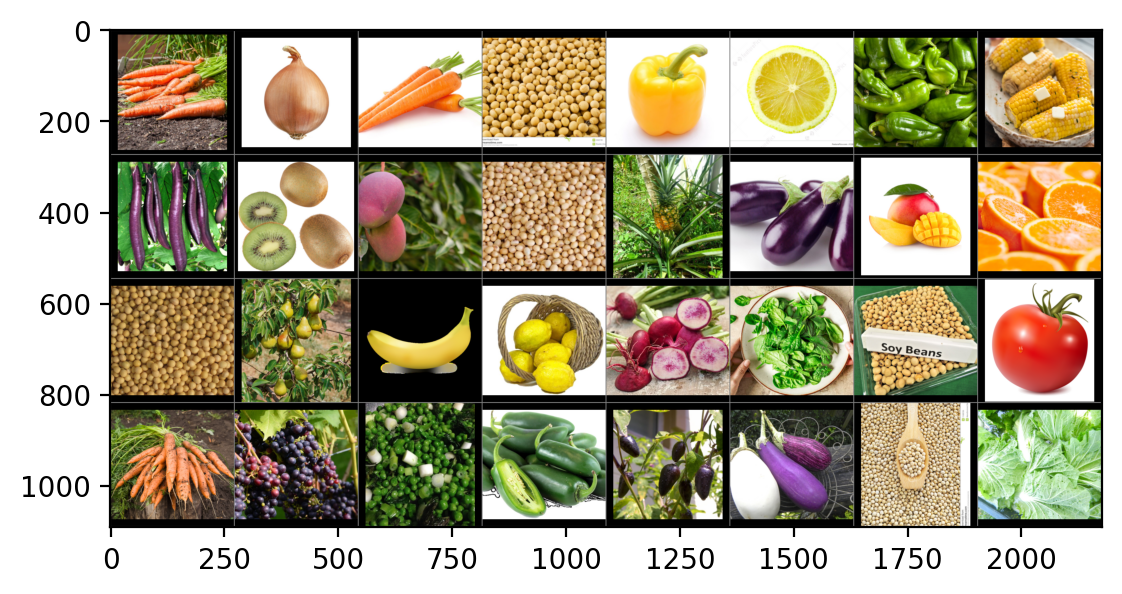

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

#### Define Neural Network


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(65536, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#### Define loss function and optimiser

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Train the model

In [ ]:
epoch_losses = []

for epoch in range(80):  
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False), 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_epoch_loss = running_loss / len(train_dataloader)
    epoch_losses.append(avg_epoch_loss)
    #print(f'Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}')

plt.plot(range(1, 101), epoch_losses, label="Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.legend()
plt.show()
plt.save("../Results/LossEachEpoch.jpg")
print('Finished Training')



Epoch 1:   6%|▌         | 6/98 [00:04<01:15,  1.22it/s]/Users/adenrelekomolafe/Documents/Personal Projects/Fruit and veg/myenv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 5:  63%|██████▎   | 62/98 [00:49<00:29,  1.23it/s]

## Test

In [ ]:
# Initialize metrics
accuracy = MulticlassAccuracy(num_classes=36)  
precision = Precision(num_classes=36, task="multiclass")
recall = Recall(num_classes=36, task="multiclass")
f1_score = F1Score(num_classes=36, task="multiclass")

In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update metrics
        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)

# Get the final metric values
print(f'Accuracy: {accuracy.compute() * 100:.2f}%')
print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'F1-Score: {f1_score.compute()}')

Accuracy: 95.77%
Precision: 0.9582172632217407
Recall: 0.9582172632217407
F1-Score: 0.9582172632217407


In [ ]:
all_preds = []
all_labels = []
classes = test_dataloader.dataset.classes

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print a detailed classification report
print(metrics.classification_report(all_labels, all_preds, target_names=classes))

               precision    recall  f1-score   support

        apple       1.00      0.70      0.82        10
       banana       1.00      0.78      0.88         9
     beetroot       0.91      1.00      0.95        10
  bell pepper       0.83      1.00      0.91        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.80      0.89        10
       carrot       0.90      0.90      0.90        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.90      0.95        10
         corn       0.69      0.90      0.78        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       0.91      1.00      0.95        10
       grapes       1.00      1.00      1.00        10
     jalepeno       1.00      1.00      1.00        10
         kiwi       1.00      1.00      1.00        10
        l

## Validation

In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update metrics
        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)

# Get the final metric values
print(f'Accuracy: {accuracy.compute() * 100:.2f}%')
print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'F1-Score: {f1_score.compute()}')

Accuracy: 95.74%
Precision: 0.9577465057373047
Recall: 0.9577465057373047
F1-Score: 0.9577465057373047


In [ ]:
all_preds = []
all_labels = []
classes = val_dataloader.dataset.classes

with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print(metrics.classification_report(all_labels, all_preds, target_names=classes))

               precision    recall  f1-score   support

        apple       1.00      0.70      0.82        10
       banana       1.00      0.78      0.88         9
     beetroot       0.91      1.00      0.95        10
  bell pepper       0.82      1.00      0.90         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.80      0.89        10
       carrot       0.89      0.89      0.89         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.89      0.94         9
         corn       0.69      0.90      0.78        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       0.91      1.00      0.95        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00         9
         kiwi       1.00      1.00      1.00        10
        l

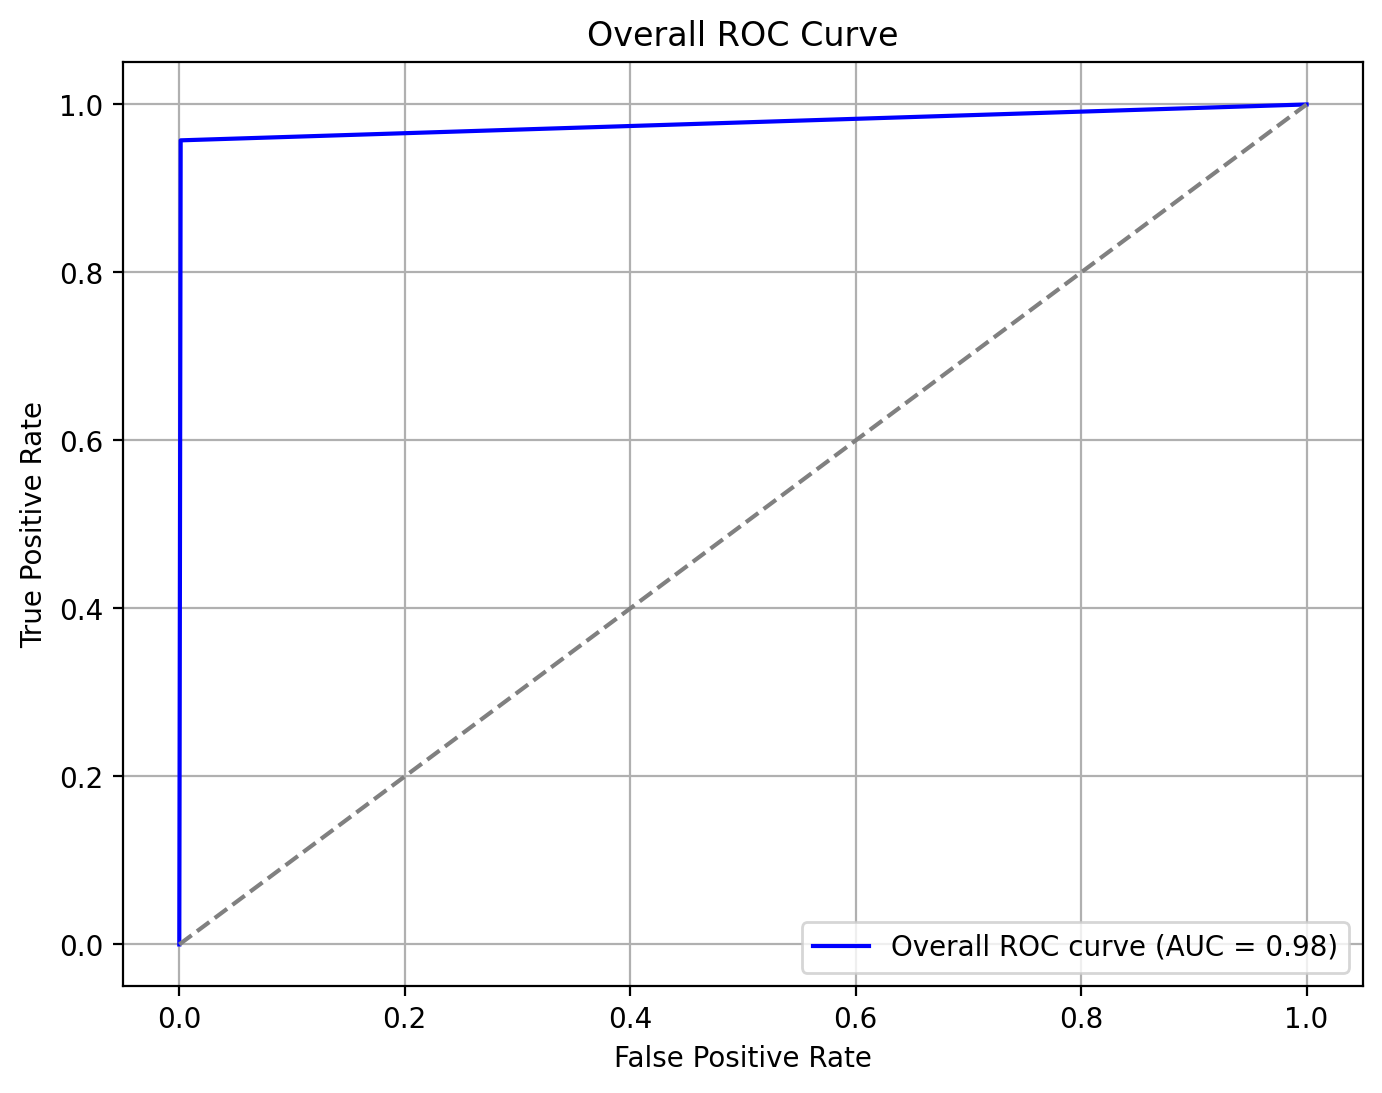

In [ ]:
y_true_bin = label_binarize(all_labels, classes=range(len(classes)))
y_pred_bin = label_binarize(all_preds, classes=range(len(classes)))


fpr, tpr, _ = metrics.roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc = metrics.auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Overall ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve")
plt.legend()
plt.grid()
plt.show()
plt.save("../Results/RocCurve.jpg")

# Save Model

In [ ]:
model_file_name = "fruit_veg.pth"
torch.save(net.state_dict(),model_file_name)

source = model_file_name
destination = "../" + model_file_name

#copy model to the directory that can be used by the main.py file
with open(source, "rb") as src, open(destination, "wb") as dest:
    while chunk := src.read(4096):  
        dest.write(chunk)


Model copied successfully
